In this script we're plotting the gender counts in each genre across time to see trends in data. The goal is to evaluate whether our data supports such an analysis.

In [164]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from scipy.stats import ttest_ind, ks_2samp, t, pointbiserialr
import json

In [165]:
# Import clean character metadata
character_meta_genre = pd.read_csv('./data/character_meta_genre.csv')
character_meta_genre.head()

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height (in meters),Actor ethnicity (Freebase ID),Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID,Genres Reduced
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,"['Adventure', 'Action', 'Western', 'Science Fi..."
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,"['Adventure', 'Action', 'Western', 'Science Fi..."
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,"['Adventure', 'Action', 'Western', 'Science Fi..."
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,"['Adventure', 'Action', 'Western', 'Science Fi..."
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,"['Adventure', 'Action', 'Western', 'Science Fi..."


In [166]:
# Function to safely convert string representations of lists into actual lists
def string_to_list(list_string):
    try:
        # This safely evaluates a string as a list
        return ast.literal_eval(list_string)
    except ValueError:
        # In case of error (e.g., empty strings), return an empty list
        return []

In [167]:
character_meta_genre['Genres Reduced'] = character_meta_genre['Genres Reduced'].apply(string_to_list)

character_meta_genre.head()

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height (in meters),Actor ethnicity (Freebase ID),Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID,Genres Reduced
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,"[Adventure, Action, Western, Science Fiction, ..."
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,"[Adventure, Action, Western, Science Fiction, ..."
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,"[Adventure, Action, Western, Science Fiction, ..."
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,"[Adventure, Action, Western, Science Fiction, ..."
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,"[Adventure, Action, Western, Science Fiction, ..."


### Step 1: Check gender missing values

In [168]:
# Are wikipedia movie ID's unique?
if character_meta_genre['Wikipedia movie ID'].nunique() == character_meta_genre['Freebase movie ID'].nunique():
    print(f"The wikipedia IDs are unique for each movie")


The wikipedia IDs are unique for each movie


In [169]:
# Also how many nan values do we have in the gender column?
print(f"We have {character_meta_genre['Actor gender'].isna().sum()} missing genders")

# What proportion of the genders is this?
print(f"This is {(character_meta_genre['Actor gender'].isna().sum()/character_meta_genre['Actor gender'].count())*100:.2f}% of values")

# Is this acceptable
print(f"Is this acceptable? Assume it is because it's small?")

We have 45609 missing genders
This is 11.26% of values
Is this acceptable? Assume it is because it's small?


In [170]:
# Keep only wikipedia IDs, movie release date, actor gender and genre
character_meta_genre_ = character_meta_genre[['Wikipedia movie ID', 
                                             'Movie release date', 
                                             'Actor gender', 
                                             'Genres Reduced']]

# Visualise result
character_meta_genre_.head()

,Wikipedia movie ID,Movie release date,Actor gender,Genres Reduced
0,975900,2001-08-24,F,"[Adventure, Action, Western, Science Fiction, ..."
1,975900,2001-08-24,F,"[Adventure, Action, Western, Science Fiction, ..."
2,975900,2001-08-24,M,"[Adventure, Action, Western, Science Fiction, ..."
3,975900,2001-08-24,M,"[Adventure, Action, Western, Science Fiction, ..."
4,975900,2001-08-24,F,"[Adventure, Action, Western, Science Fiction, ..."


In [171]:
# How many nan values in genre?
print(f"Number of missing values in genres: {character_meta_genre_['Genres Reduced'].isna().sum()}")
print(f"The percentage of missing genres is: {character_meta_genre_['Genres Reduced'].isna().sum()/character_meta_genre_['Genres Reduced'].count()*100:.2f}%")

if character_meta_genre_['Genres Reduced'].isna().sum()/character_meta_genre_['Genres Reduced'].count()*100<15:
    print(f"We assume percentage of missing values negligible and we drop them")

Number of missing values in genres: 0
The percentage of missing genres is: 0.00%
We assume percentage of missing values negligible and we drop them


In [172]:
# Drop missing genre rows
character_meta_genre_ = character_meta_genre_[character_meta_genre_['Genres Reduced'].notna()]

In [173]:
# We want to group by genre. We first need to convert lists to tuples bc lists are mutable
character_meta_genre_['Genres Reduced'] = character_meta_genre_['Genres Reduced'].apply(tuple)

character_meta_genre_.head()

,Wikipedia movie ID,Movie release date,Actor gender,Genres Reduced
0,975900,2001-08-24,F,"(Adventure, Action, Western, Science Fiction, ..."
1,975900,2001-08-24,F,"(Adventure, Action, Western, Science Fiction, ..."
2,975900,2001-08-24,M,"(Adventure, Action, Western, Science Fiction, ..."
3,975900,2001-08-24,M,"(Adventure, Action, Western, Science Fiction, ..."
4,975900,2001-08-24,F,"(Adventure, Action, Western, Science Fiction, ..."


In [174]:
# Function that transforms all our dates into one format that maintains only the year
def release_date_format(value): 
    if isinstance(value, str) and value.startswith(('18', '19', '20')): # no movies before 1800
        return value[:4]
    else:
        return pd.NA 

In [175]:
character_meta_genre_['Movie release date'] = character_meta_genre_['Movie release date'].apply(release_date_format)

character_meta_genre_.head()

,Wikipedia movie ID,Movie release date,Actor gender,Genres Reduced
0,975900,2001,F,"(Adventure, Action, Western, Science Fiction, ..."
1,975900,2001,F,"(Adventure, Action, Western, Science Fiction, ..."
2,975900,2001,M,"(Adventure, Action, Western, Science Fiction, ..."
3,975900,2001,M,"(Adventure, Action, Western, Science Fiction, ..."
4,975900,2001,F,"(Adventure, Action, Western, Science Fiction, ..."


In [176]:
# Drop nan
print(f"Number of missing values in dates: {(character_meta_genre_['Movie release date'].isna().sum()/character_meta_genre_['Movie release date'].count())*100:.4f}%")

if (character_meta_genre_['Movie release date'].isna().sum()/character_meta_genre_['Movie release date'].count())*100<15:
    print(f"The number of missing data in dates is insignicant so we'll drop them")
    character_meta_genre_ = character_meta_genre_[character_meta_genre_['Movie release date'].notna()]


Number of missing values in dates: 2.2716%
The number of missing data in dates is insignicant so we'll drop them


In [177]:
character_meta_genre_['Movie release date'] = character_meta_genre_['Movie release date'].apply(lambda x: int(x))

In [178]:
# Explode the genre tuples
character_meta_genre_exploded = character_meta_genre_.explode('Genres Reduced')

character_meta_genre_exploded.head()

,Wikipedia movie ID,Movie release date,Actor gender,Genres Reduced
0,975900,2001,F,Adventure
0,975900,2001,F,Action
0,975900,2001,F,Western
0,975900,2001,F,Science Fiction
0,975900,2001,F,Thriller


In [179]:
# function to count number of females 
def count_females(column):
    f_count = column.value_counts()['F']
    return f_count

# function to count number of males
def count_males(column):
    m_count = column.value_counts()['M']
    return m_count


In [180]:

# For each genre and year count the number of females and males
character_meta_genre_year = character_meta_genre_exploded.groupby(['Movie release date', 
                                                                   'Genres Reduced']).agg(Female_count_year = ('Actor gender',  
                                                                                                lambda x: (x == 'F').sum()),
                                                                                            Male_count_year = ('Actor gender',
                                                                                                lambda x: (x == 'M').sum())).reset_index()

character_meta_genre_year.head()

,Movie release date,Genres Reduced,Female_count_year,Male_count_year
0,1888,Black and White,2,2
1,1888,Independent,2,2
2,1888,Short Film,2,2
3,1888,Silent,2,2
4,1891,Independent,0,1


In [181]:
# Make list of unique genres
unique_genres = set(character_meta_genre_year['Genres Reduced'].tolist())

# Group by genre
#For each genre create a new subplot
character_meta_genre_year_final= character_meta_genre_year.groupby('Genres Reduced').agg(Release_date_list = ('Movie release date', lambda x: list(x)),
                                                                                   F_count_list = ('Female_count_year', lambda x: list(x)),
                                                                                    M_count_list = ('Male_count_year', lambda x: list(x) )).reset_index()

character_meta_genre_year_final.head()


,Genres Reduced,Release_date_list,F_count_list,M_count_list
0,Action,"[1903, 1908, 1909, 1912, 1913, 1914, 1915, 191...","[1, 2, 0, 4, 5, 2, 6, 5, 2, 3, 3, 11, 3, 6, 6,...","[2, 7, 1, 11, 12, 5, 19, 12, 11, 13, 7, 23, 18..."
1,Adult,"[1899, 1920, 1927, 1933, 1938, 1940, 1942, 194...","[1, 0, 1, 5, 3, 5, 4, 1, 1, 3, 3, 18, 18, 3, 8...","[0, 2, 4, 3, 3, 5, 10, 3, 0, 1, 14, 14, 34, 8,..."
2,Adventure,"[1902, 1903, 1904, 1907, 1910, 1911, 1912, 191...","[2, 1, 0, 2, 1, 0, 1, 6, 9, 9, 5, 4, 10, 8, 27...","[7, 1, 1, 2, 0, 5, 1, 10, 16, 33, 12, 9, 10, 1..."
3,Animated,"[1931, 1933, 1935, 1939, 1940, 1941, 1942, 194...","[1, 1, 3, 2, 1, 6, 9, 1, 3, 2, 3, 3, 2, 3, 2, ...","[0, 2, 6, 6, 6, 14, 26, 5, 11, 7, 6, 9, 4, 4, ..."
4,Animation,"[1906, 1908, 1913, 1914, 1921, 1923, 1924, 192...","[0, 1, 0, 0, 2, 0, 2, 2, 1, 4, 3, 11, 24, 15, ...","[1, 0, 1, 4, 1, 1, 3, 4, 8, 8, 0, 2, 19, 11, 6..."


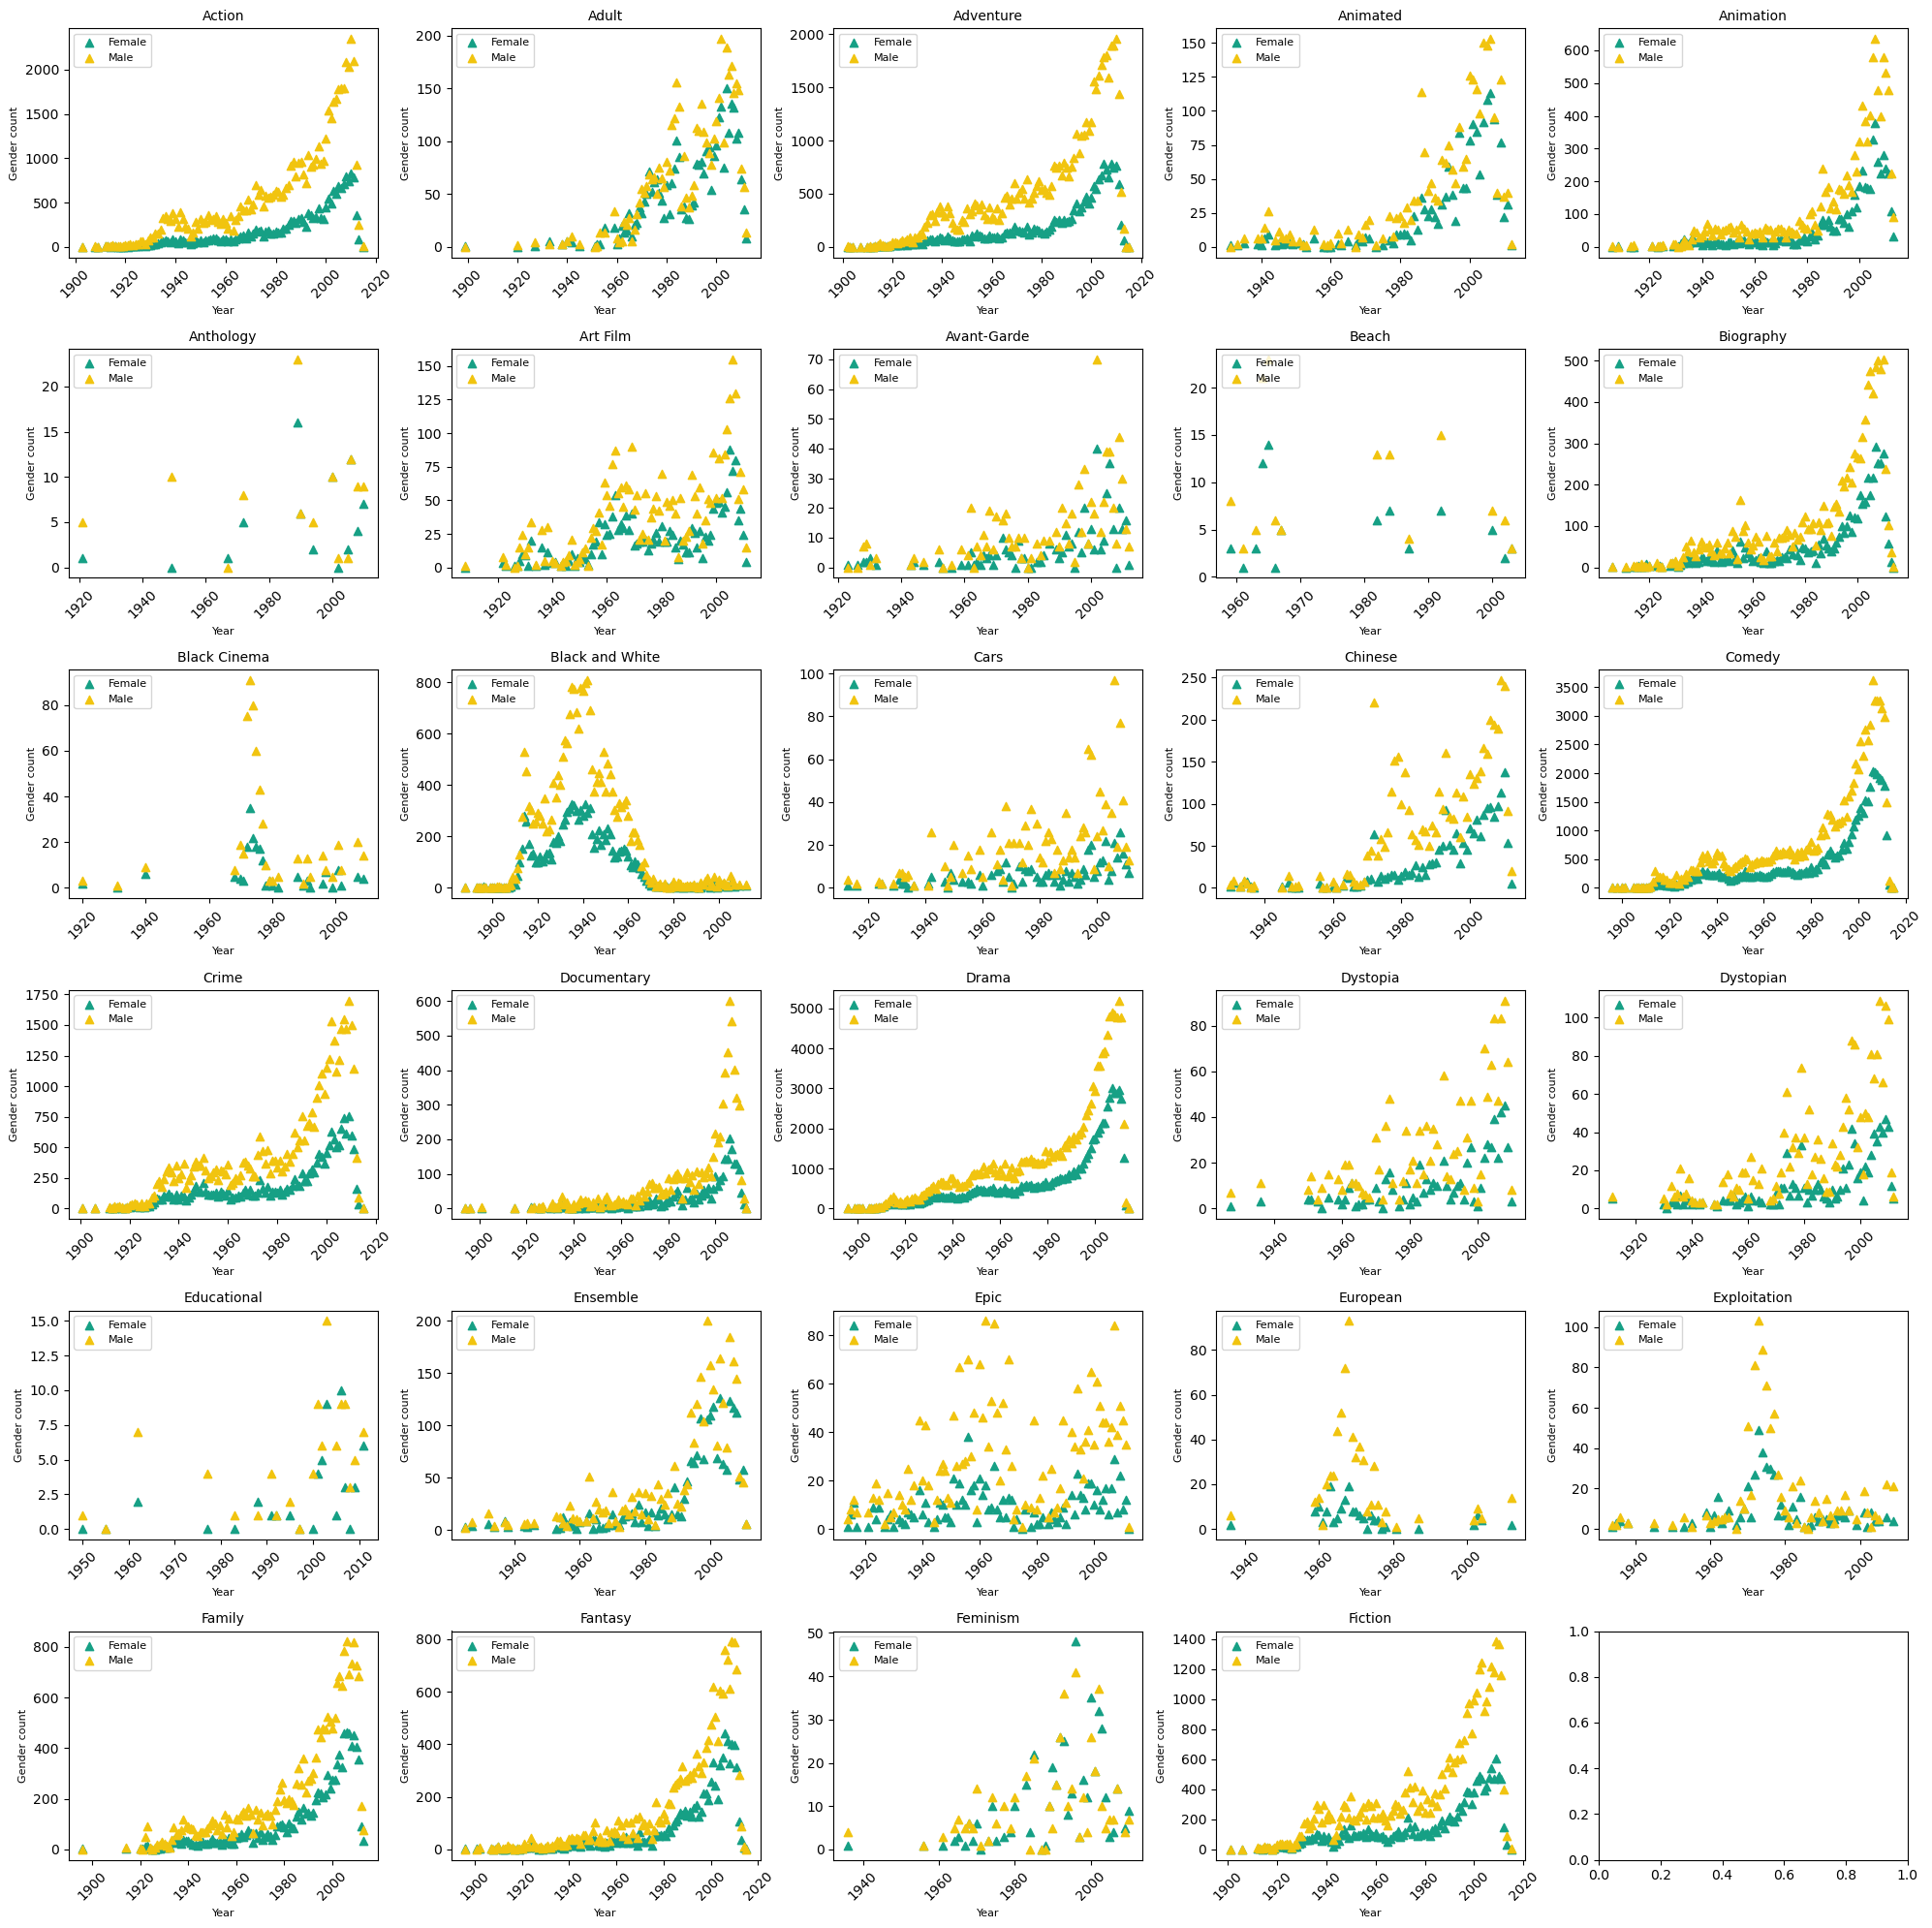

In [182]:
# Make function to create plot for subset of genres because we have 77 of them
def plot_genres(data, start_idx, end_idx):
    fig, axs = plt.subplots(nrows=6, ncols=5, figsize=(20,20))
    plt.subplots_adjust(hspace=0.5, wspace=0.5)

    for (idx, row), ax in zip(data.iloc[start_idx:end_idx].iterrows(), axs.flatten()):
        ax.scatter(row['Release_date_list'], row['F_count_list'], color='#16A085', label='Female', marker = '^')
        ax.scatter(row['Release_date_list'], row['M_count_list'], color='#F1C40F', label='Male', marker = '^')
        ax.set_title(row['Genres Reduced'], fontsize=10)
        ax.set_xlabel('Year', fontsize=8)
        ax.set_ylabel('Gender count', fontsize=8)
        ax.tick_params(axis='x', rotation=45)
        ax.legend(loc='upper left', fontsize=8)

    plt.tight_layout()
    plt.show()

plot_1 = plot_genres(character_meta_genre_year_final, 0, 29)

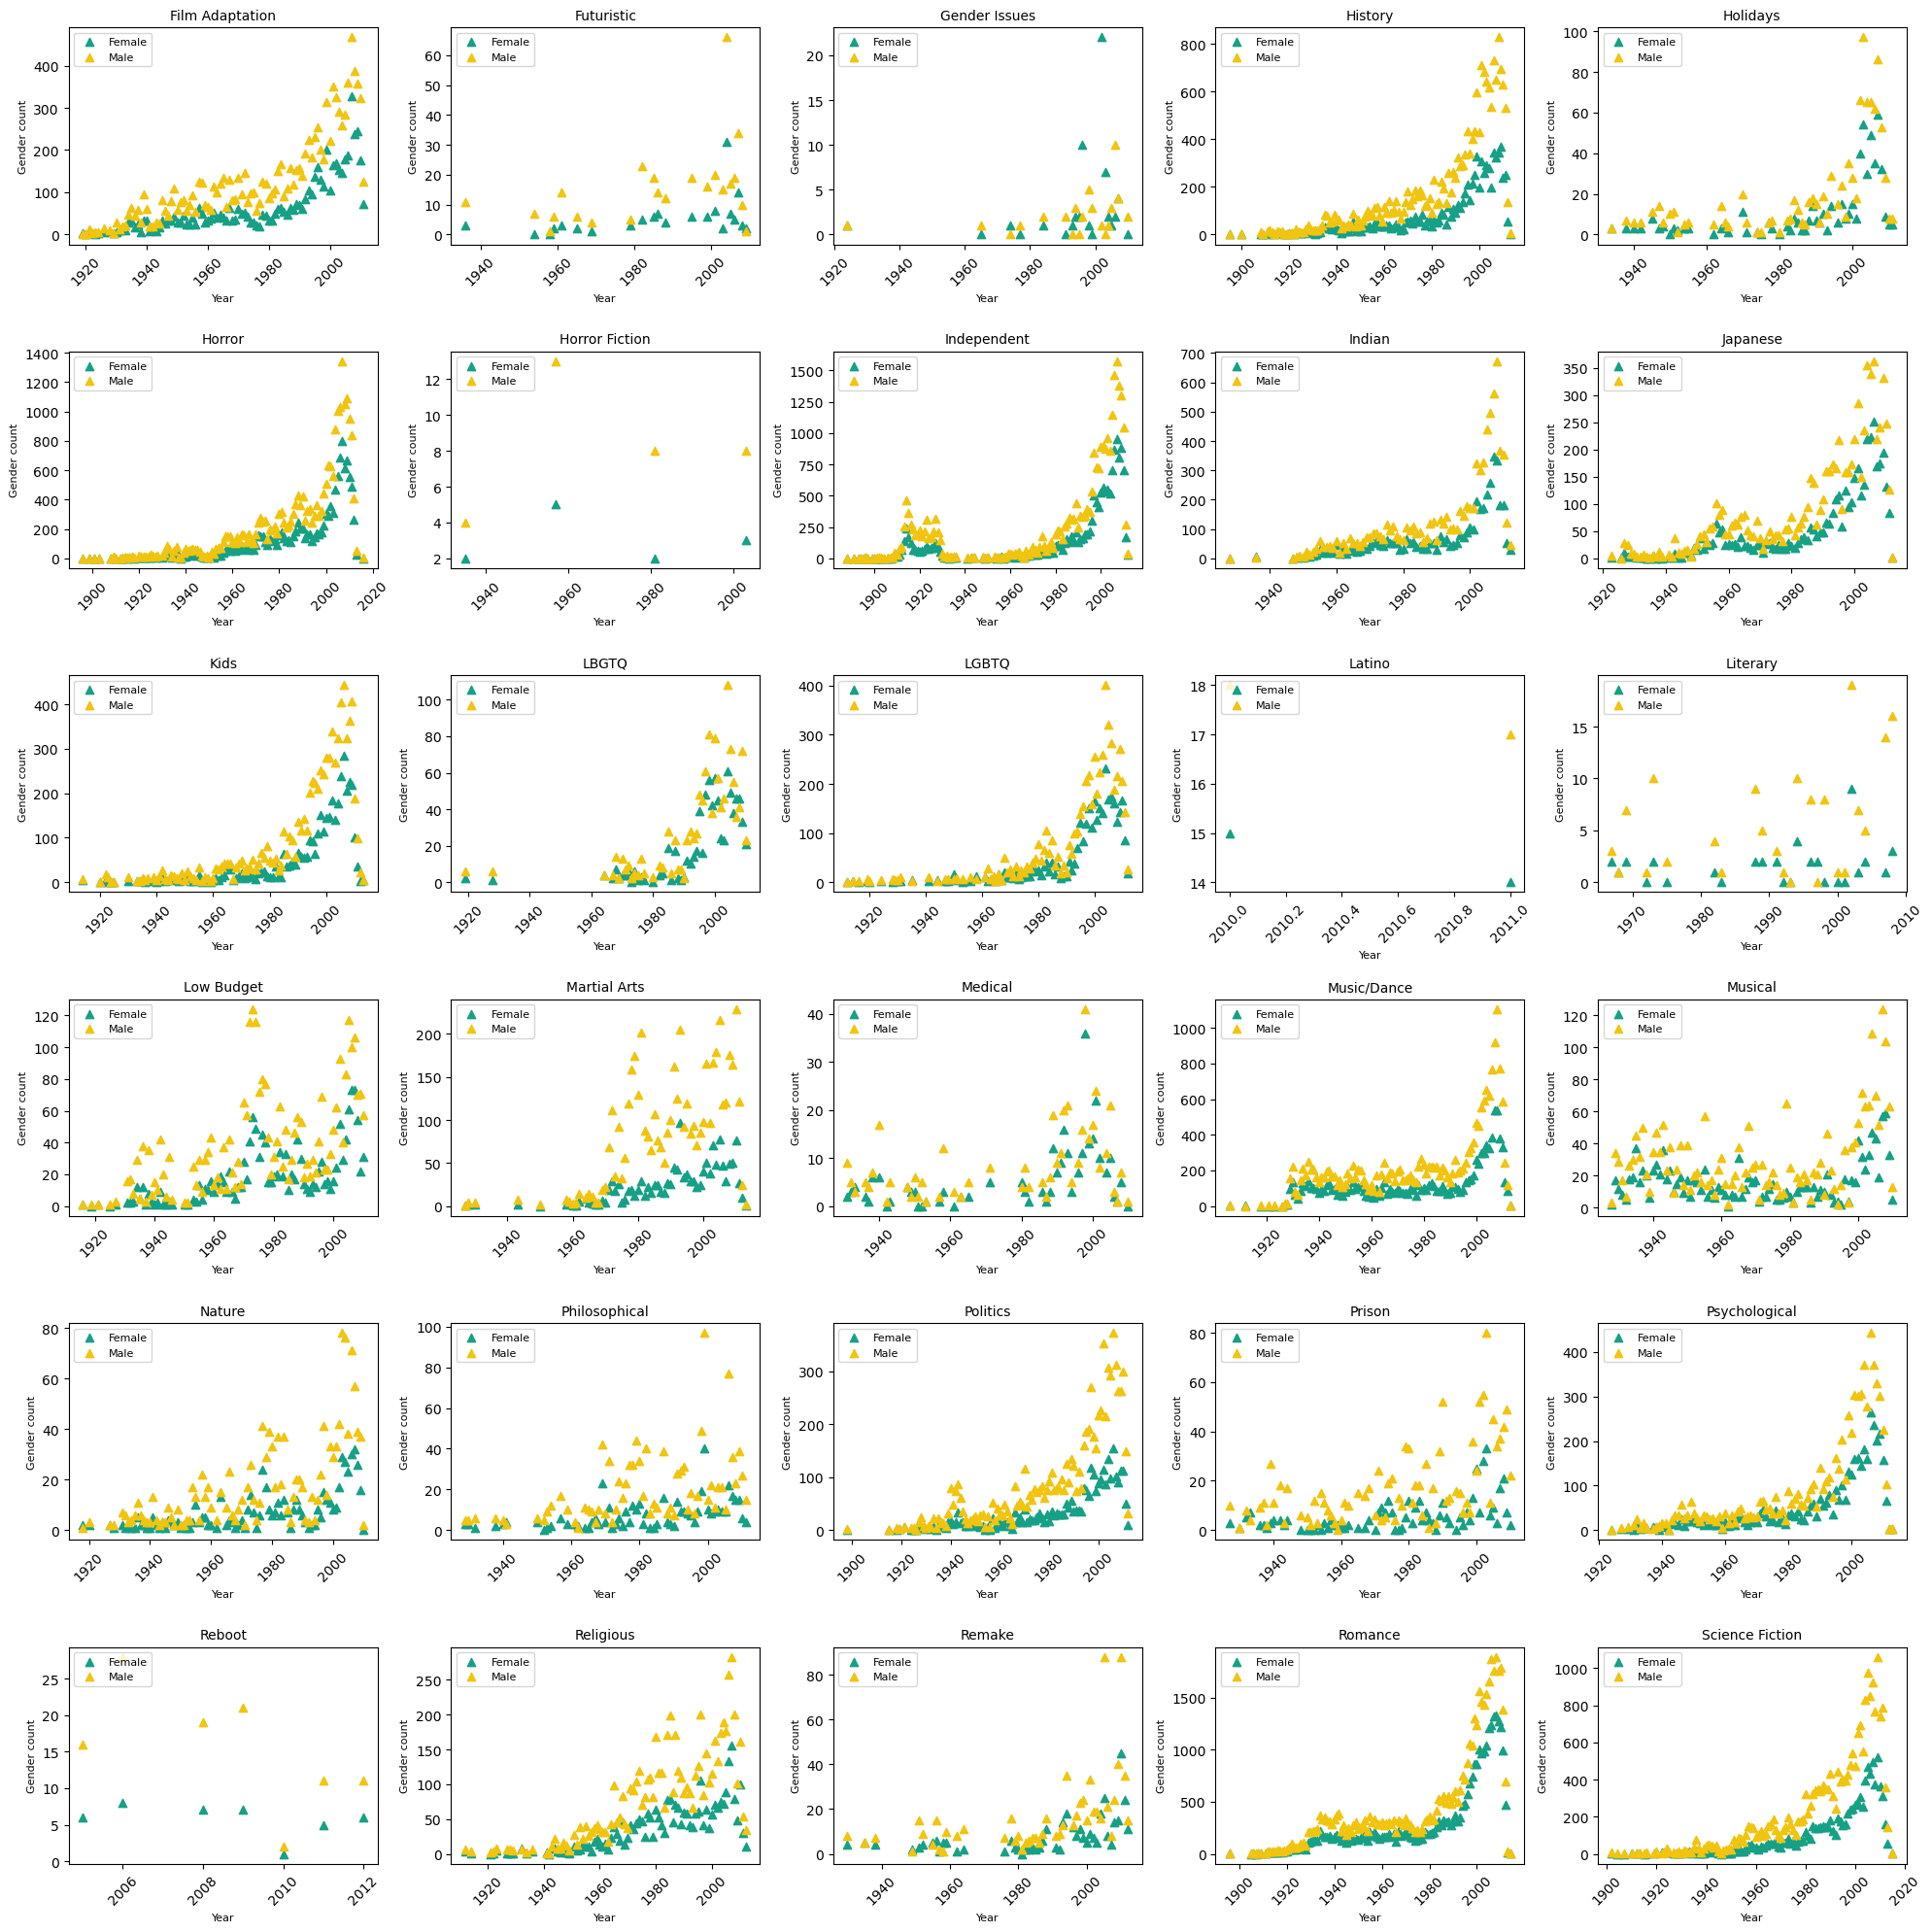

In [183]:
plot_2 = plot_genres(character_meta_genre_year_final, 30, 60)

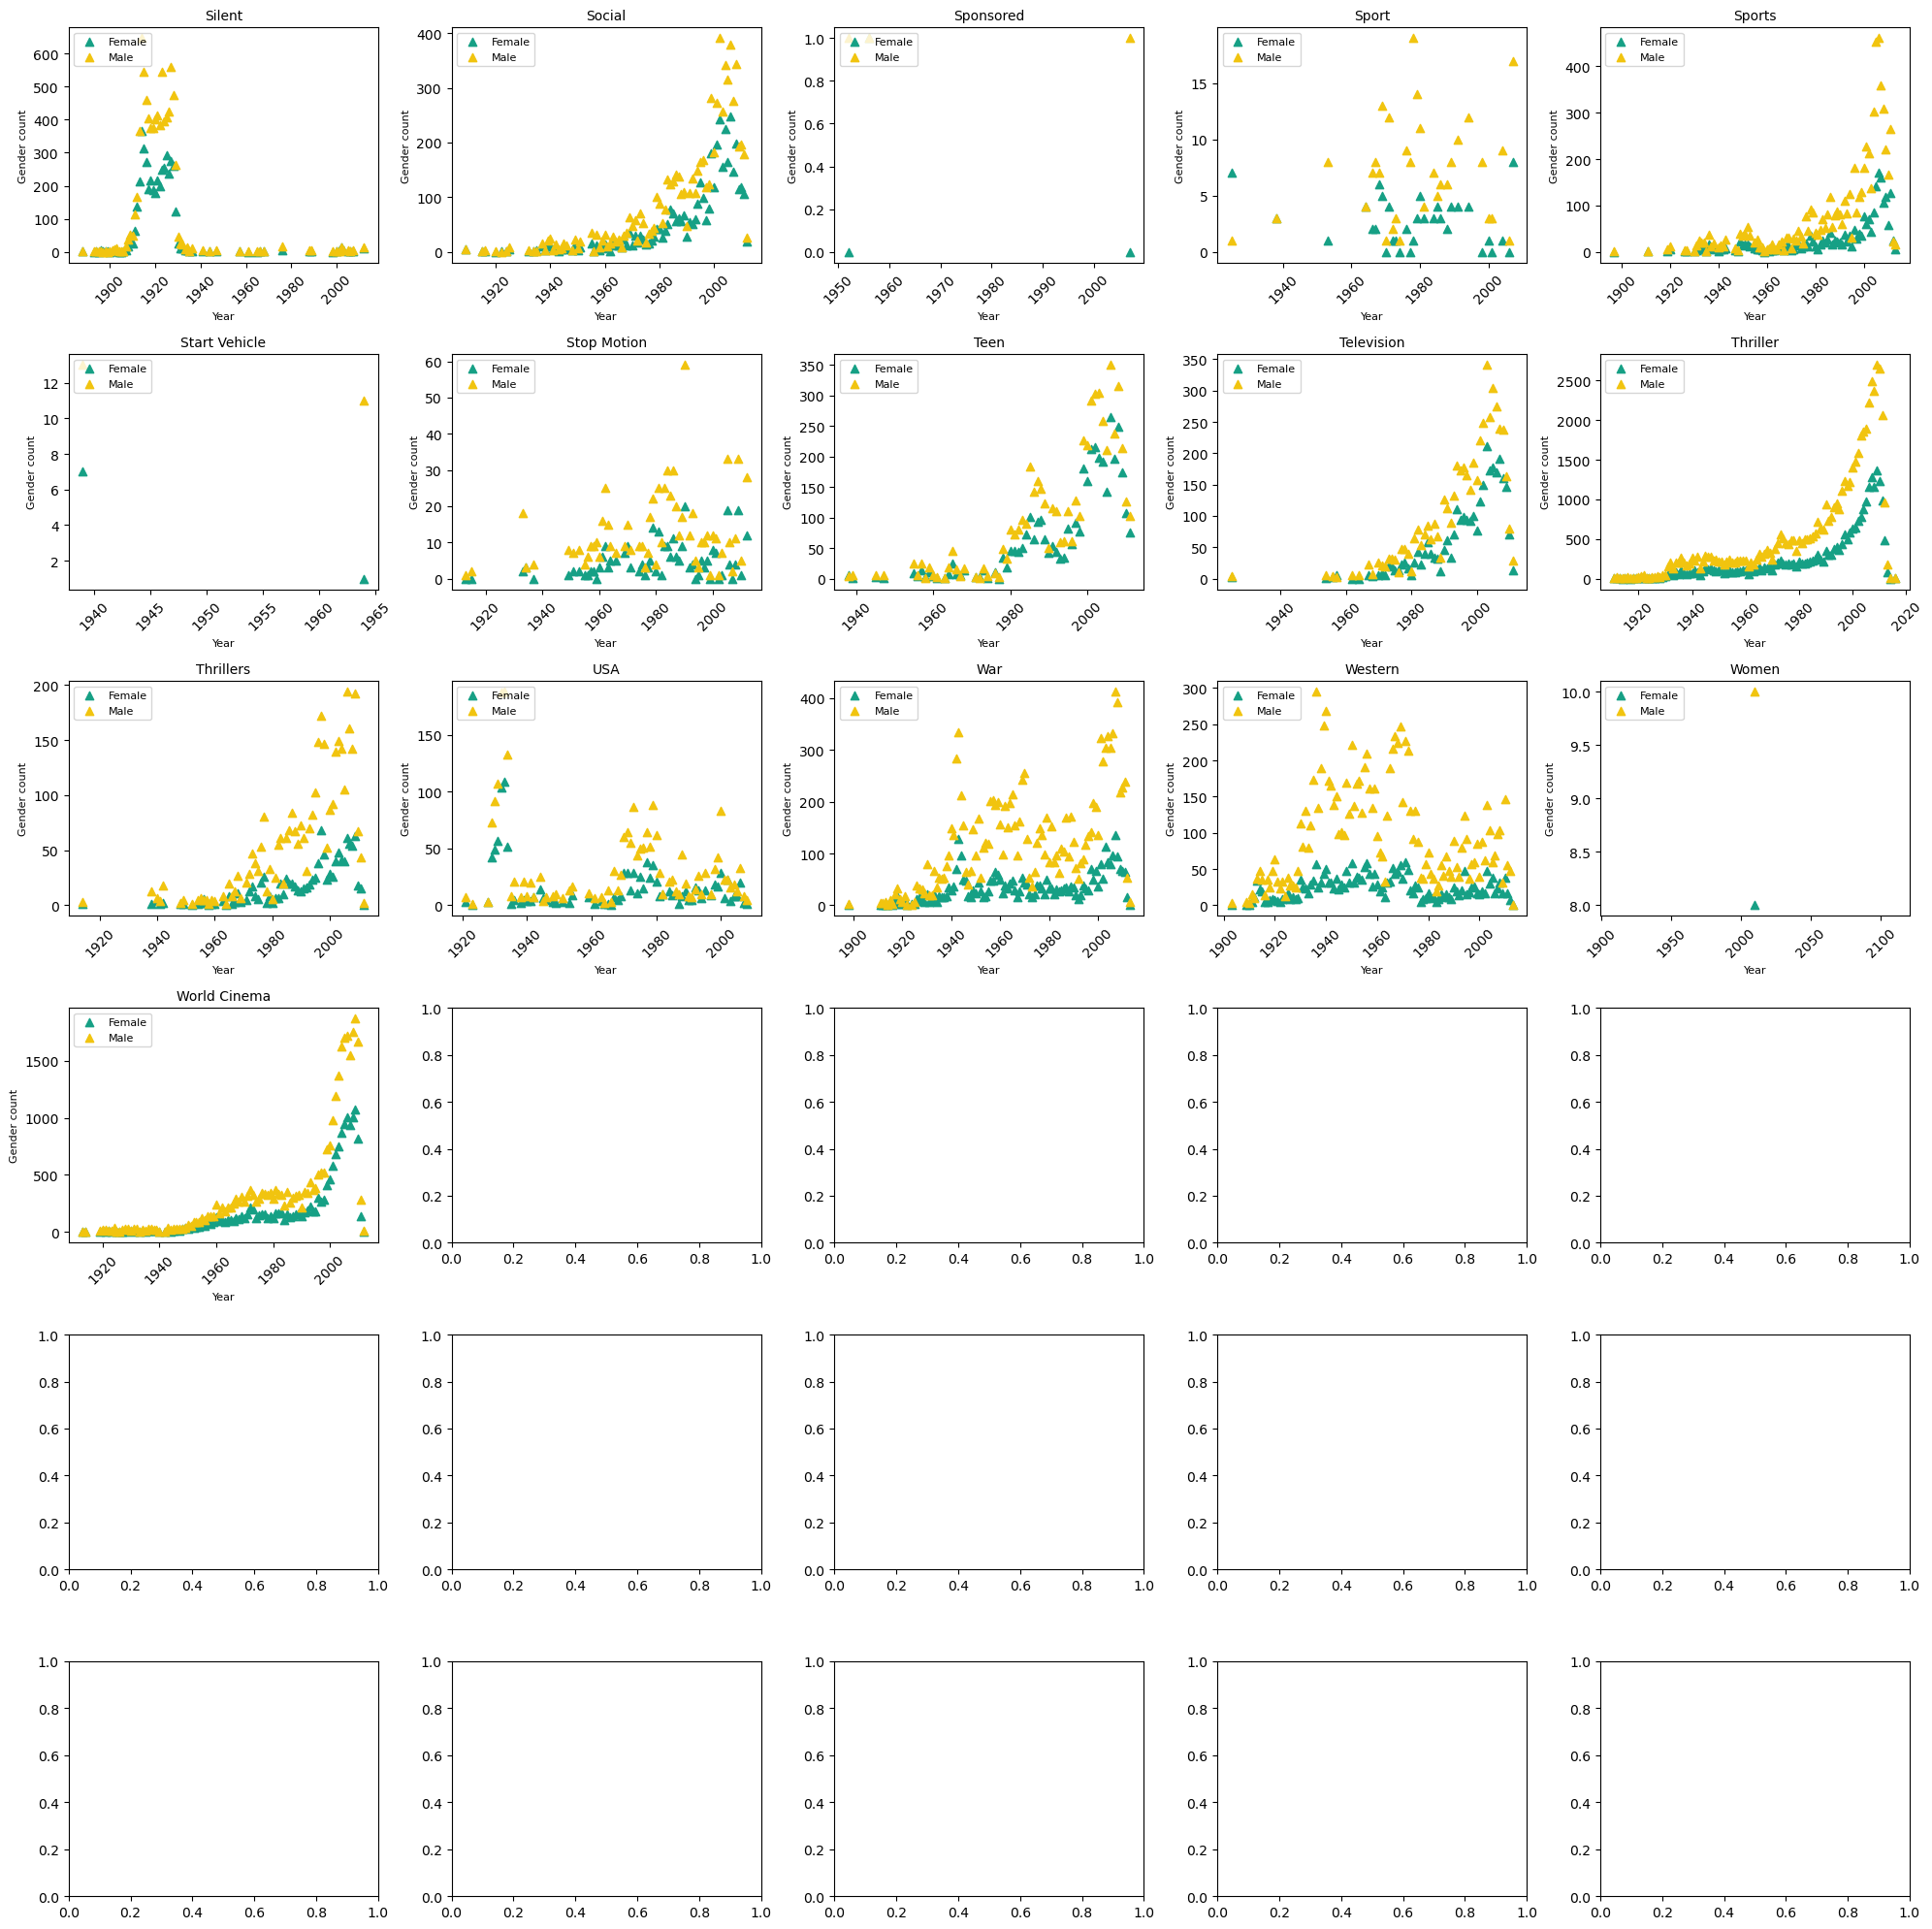

In [184]:
plot_3 = plot_genres(character_meta_genre_year_final, 61, 77)

___

### Step 2: Sample analysis

So, as you can see, even after reducing the list of unique genres, there are still some that include less data points than others. So in this section we will:

- Consider genres that do not have a lot of data. Should they be considered in assessing the counts between females and males? We can check their confidence intervals for that. If they overlap we need to discuss. Perhaps try bootstrapping.

___

In [185]:
# Let's see the current form of our dataframe
character_meta_genre_year_final.head()


,Genres Reduced,Release_date_list,F_count_list,M_count_list
0,Action,"[1903, 1908, 1909, 1912, 1913, 1914, 1915, 191...","[1, 2, 0, 4, 5, 2, 6, 5, 2, 3, 3, 11, 3, 6, 6,...","[2, 7, 1, 11, 12, 5, 19, 12, 11, 13, 7, 23, 18..."
1,Adult,"[1899, 1920, 1927, 1933, 1938, 1940, 1942, 194...","[1, 0, 1, 5, 3, 5, 4, 1, 1, 3, 3, 18, 18, 3, 8...","[0, 2, 4, 3, 3, 5, 10, 3, 0, 1, 14, 14, 34, 8,..."
2,Adventure,"[1902, 1903, 1904, 1907, 1910, 1911, 1912, 191...","[2, 1, 0, 2, 1, 0, 1, 6, 9, 9, 5, 4, 10, 8, 27...","[7, 1, 1, 2, 0, 5, 1, 10, 16, 33, 12, 9, 10, 1..."
3,Animated,"[1931, 1933, 1935, 1939, 1940, 1941, 1942, 194...","[1, 1, 3, 2, 1, 6, 9, 1, 3, 2, 3, 3, 2, 3, 2, ...","[0, 2, 6, 6, 6, 14, 26, 5, 11, 7, 6, 9, 4, 4, ..."
4,Animation,"[1906, 1908, 1913, 1914, 1921, 1923, 1924, 192...","[0, 1, 0, 0, 2, 0, 2, 2, 1, 4, 3, 11, 24, 15, ...","[1, 0, 1, 4, 1, 1, 3, 4, 8, 8, 0, 2, 19, 11, 6..."


In [186]:
def mean_confidence_interval(data, confidence=0.95):
    """Compute confidence interval for given data."""
    n = len(data)
    m, se = np.mean(data), np.std(data)
    h = se * t.ppf((1 + confidence) / 2., n-1)/np.sqrt(n)
    return [m, m-h, m+h] # new dataframe



In [187]:
# Compute mean and confidence interval for each entry gender count list

# First we get a series of lists i.e. each row is like [m,ci-,ci+] and then you go to each row and you apply pd.Series which 
# takes each list in the Series from step 1 and converts it into a row in a new DataFrame where each list element becomes a separate column.
character_meta_genre_year_final[['F_mean', 'F_CI-', 'F_CI+']]= character_meta_genre_year_final['F_count_list'].apply(mean_confidence_interval).apply(pd.Series) 
character_meta_genre_year_final[['M_mean', 'M_CI-', 'M_CI+']]= character_meta_genre_year_final['M_count_list'].apply(mean_confidence_interval).apply(pd.Series) 

character_meta_genre_year_final.head()

,Genres Reduced,Release_date_list,F_count_list,M_count_list,F_mean,F_CI-,F_CI+,M_mean,M_CI-,M_CI+
0,Action,"[1903, 1908, 1909, 1912, 1913, 1914, 1915, 191...","[1, 2, 0, 4, 5, 2, 6, 5, 2, 3, 3, 11, 3, 6, 6,...","[2, 7, 1, 11, 12, 5, 19, 12, 11, 13, 7, 23, 18...",175.839623,136.360313,215.318932,536.707547,432.072440,641.342654
1,Adult,"[1899, 1920, 1927, 1933, 1938, 1940, 1942, 194...","[1, 0, 1, 5, 3, 5, 4, 1, 1, 3, 3, 18, 18, 3, 8...","[0, 2, 4, 3, 3, 5, 10, 3, 0, 1, 14, 14, 34, 8,...",49.454545,39.651891,59.257200,66.515152,53.239795,79.790508
2,Adventure,"[1902, 1903, 1904, 1907, 1910, 1911, 1912, 191...","[2, 1, 0, 2, 1, 0, 1, 6, 9, 9, 5, 4, 10, 8, 27...","[7, 1, 1, 2, 0, 5, 1, 10, 16, 33, 12, 9, 10, 1...",171.263636,133.252082,209.275191,493.690909,399.951236,587.430582
3,Animated,"[1931, 1933, 1935, 1939, 1940, 1941, 1942, 194...","[1, 1, 3, 2, 1, 6, 9, 1, 3, 2, 3, 3, 2, 3, 2, ...","[0, 2, 6, 6, 6, 14, 26, 5, 11, 7, 6, 9, 4, 4, ...",23.560606,16.017735,31.103477,38.363636,27.871197,48.856075
4,Animation,"[1906, 1908, 1913, 1914, 1921, 1923, 1924, 192...","[0, 1, 0, 0, 2, 0, 2, 2, 1, 4, 3, 11, 24, 15, ...","[1, 0, 1, 4, 1, 1, 3, 4, 8, 8, 0, 2, 19, 11, 6...",55.150538,38.600550,71.700525,119.204301,88.537620,149.870982


In [196]:
# Now check for overlapping intervals
def check_cioverlap(df, column_1 = 'M_CI-', column_2 = 'F_CI+', 
                    column_3 = 'F_CI-', column_4 = 'M_CI+', f_mean = 'F_mean', m_mean = 'M_mean'):
    
    overlap_indicator = []
    for index, row in character_meta_genre_year_final.iterrows():
        if row[f_mean] < row[m_mean] and row[column_1] < row[column_2]:
            overlap_indicator.append(1) 
        elif row[m_mean] < row[f_mean] and row[column_3] < row[column_4]:
            overlap_indicator.append(1) 
        else:
            overlap_indicator.append(0) 
    return pd.Series(overlap_indicator)
    
character_meta_genre_year_final['CI binary indicator'] = check_cioverlap(character_meta_genre_year_final, column_1 = 'M_CI-', column_2 = 'F_CI+', column_3 = 'F_CI-', column_4 = 'M_CI+')




In [198]:
# Print warning if there's overlaps
mask = character_meta_genre_year_final['CI binary indicator'] == 1
if len(character_meta_genre_year_final[character_meta_genre_year_final['CI binary indicator'] == 1]) > 0:
    print('We have overlapping confidence intervals in genres:')
    display(character_meta_genre_year_final[character_meta_genre_year_final['CI binary indicator'] == 1])
else:
    print('No overlapping confidence intervals')

We have overlapping confidence intervals in genres:


,Genres Reduced,Release_date_list,F_count_list,M_count_list,F_mean,F_CI-,F_CI+,M_mean,M_CI-,M_CI+,CI binary indicator,Female,Male
1,Adult,"[1899, 1920, 1927, 1933, 1938, 1940, 1942, 194...","[1, 0, 1, 5, 3, 5, 4, 1, 1, 3, 3, 18, 18, 3, 8...","[0, 2, 4, 3, 3, 5, 10, 3, 0, 1, 14, 14, 34, 8,...",49.454545,39.651891,59.257200,66.515152,53.239795,79.790508,1,F,M
3,Animated,"[1931, 1933, 1935, 1939, 1940, 1941, 1942, 194...","[1, 1, 3, 2, 1, 6, 9, 1, 3, 2, 3, 3, 2, 3, 2, ...","[0, 2, 6, 6, 6, 14, 26, 5, 11, 7, 6, 9, 4, 4, ...",23.560606,16.017735,31.103477,38.363636,27.871197,48.856075,1,F,M
5,Anthology,"[1921, 1949, 1967, 1972, 1989, 1990, 1994, 200...","[1, 0, 1, 5, 16, 6, 2, 10, 0, 2, 12, 4, 7]","[5, 10, 0, 8, 23, 6, 5, 10, 1, 1, 12, 9, 9]",5.076923,2.169526,7.984320,7.615385,4.127524,11.103245,1,F,M
8,Beach,"[1959, 1961, 1963, 1964, 1965, 1966, 1967, 198...","[3, 1, 3, 12, 14, 1, 5, 6, 7, 3, 7, 5, 2, 3]","[8, 3, 5, 21, 23, 6, 5, 13, 13, 4, 15, 7, 6, 3]",5.142857,2.984064,7.301651,9.428571,5.785276,13.071867,1,F,M
20,Educational,"[1950, 1955, 1962, 1977, 1983, 1988, 1991, 199...","[0, 0, 2, 0, 0, 2, 1, 1, 1, 0, 0, 4, 5, 9, 1, ...","[1, 0, 7, 4, 1, 1, 4, 1, 2, 0, 4, 9, 6, 15, 6,...",2.400000,1.024324,3.775676,4.700000,2.929569,6.470431,1,F,M
21,Ensemble,"[1925, 1927, 1932, 1934, 1937, 1938, 1943, 194...","[3, 4, 6, 3, 9, 3, 4, 3, 5, 1, 2, 12, 5, 8, 4,...","[2, 8, 16, 4, 8, 5, 6, 7, 7, 13, 12, 7, 4, 23,...",29.865672,20.830298,38.901045,45.313433,32.673946,57.952920,1,F,M
24,Exploitation,"[1934, 1935, 1936, 1938, 1945, 1950, 1953, 195...","[1, 3, 4, 3, 1, 1, 1, 3, 8, 1, 7, 16, 3, 6, 9,...","[2, 2, 6, 3, 3, 2, 6, 1, 7, 3, 4, 5, 5, 6, 6, ...",8.740741,6.006123,11.475359,16.666667,10.333519,22.999815,1,F,M
27,Feminism,"[1936, 1956, 1961, 1964, 1965, 1967, 1968, 196...","[1, 1, 1, 2, 3, 1, 6, 2, 6, 0, 2, 10, 2, 3, 4,...","[4, 1, 3, 5, 7, 5, 6, 5, 14, 1, 2, 12, 6, 10, ...",10.738095,7.348196,14.127994,10.642857,7.552849,13.732865,1,F,M
29,Filipino,"[1919, 1937, 1939, 1940, 1947, 1951, 1952, 195...","[1, 3, 2, 2, 1, 9, 1, 12, 1, 7, 2, 1, 3, 1, 2,...","[0, 4, 4, 1, 0, 3, 1, 12, 2, 6, 0, 3, 7, 2, 13...",15.357143,8.123055,22.591230,18.142857,10.693685,25.592029,1,F,M
32,Gender Issues,"[1924, 1965, 1974, 1977, 1984, 1991, 1993, 199...","[1, 0, 1, 0, 1, 0, 1, 2, 2, 10, 1, 0, 22, 7, 2...","[1, 1, 0, 1, 2, 2, 0, 3, 0, 2, 5, 3, 1, 0, 1, ...",3.000000,0.527471,5.472529,2.157895,1.049240,3.266549,1,F,M


______

Let's make statistical plots for all genres to better understand if our data is comparable. We'll make confidence interval plots for all and
box plots for the female and male data.

______

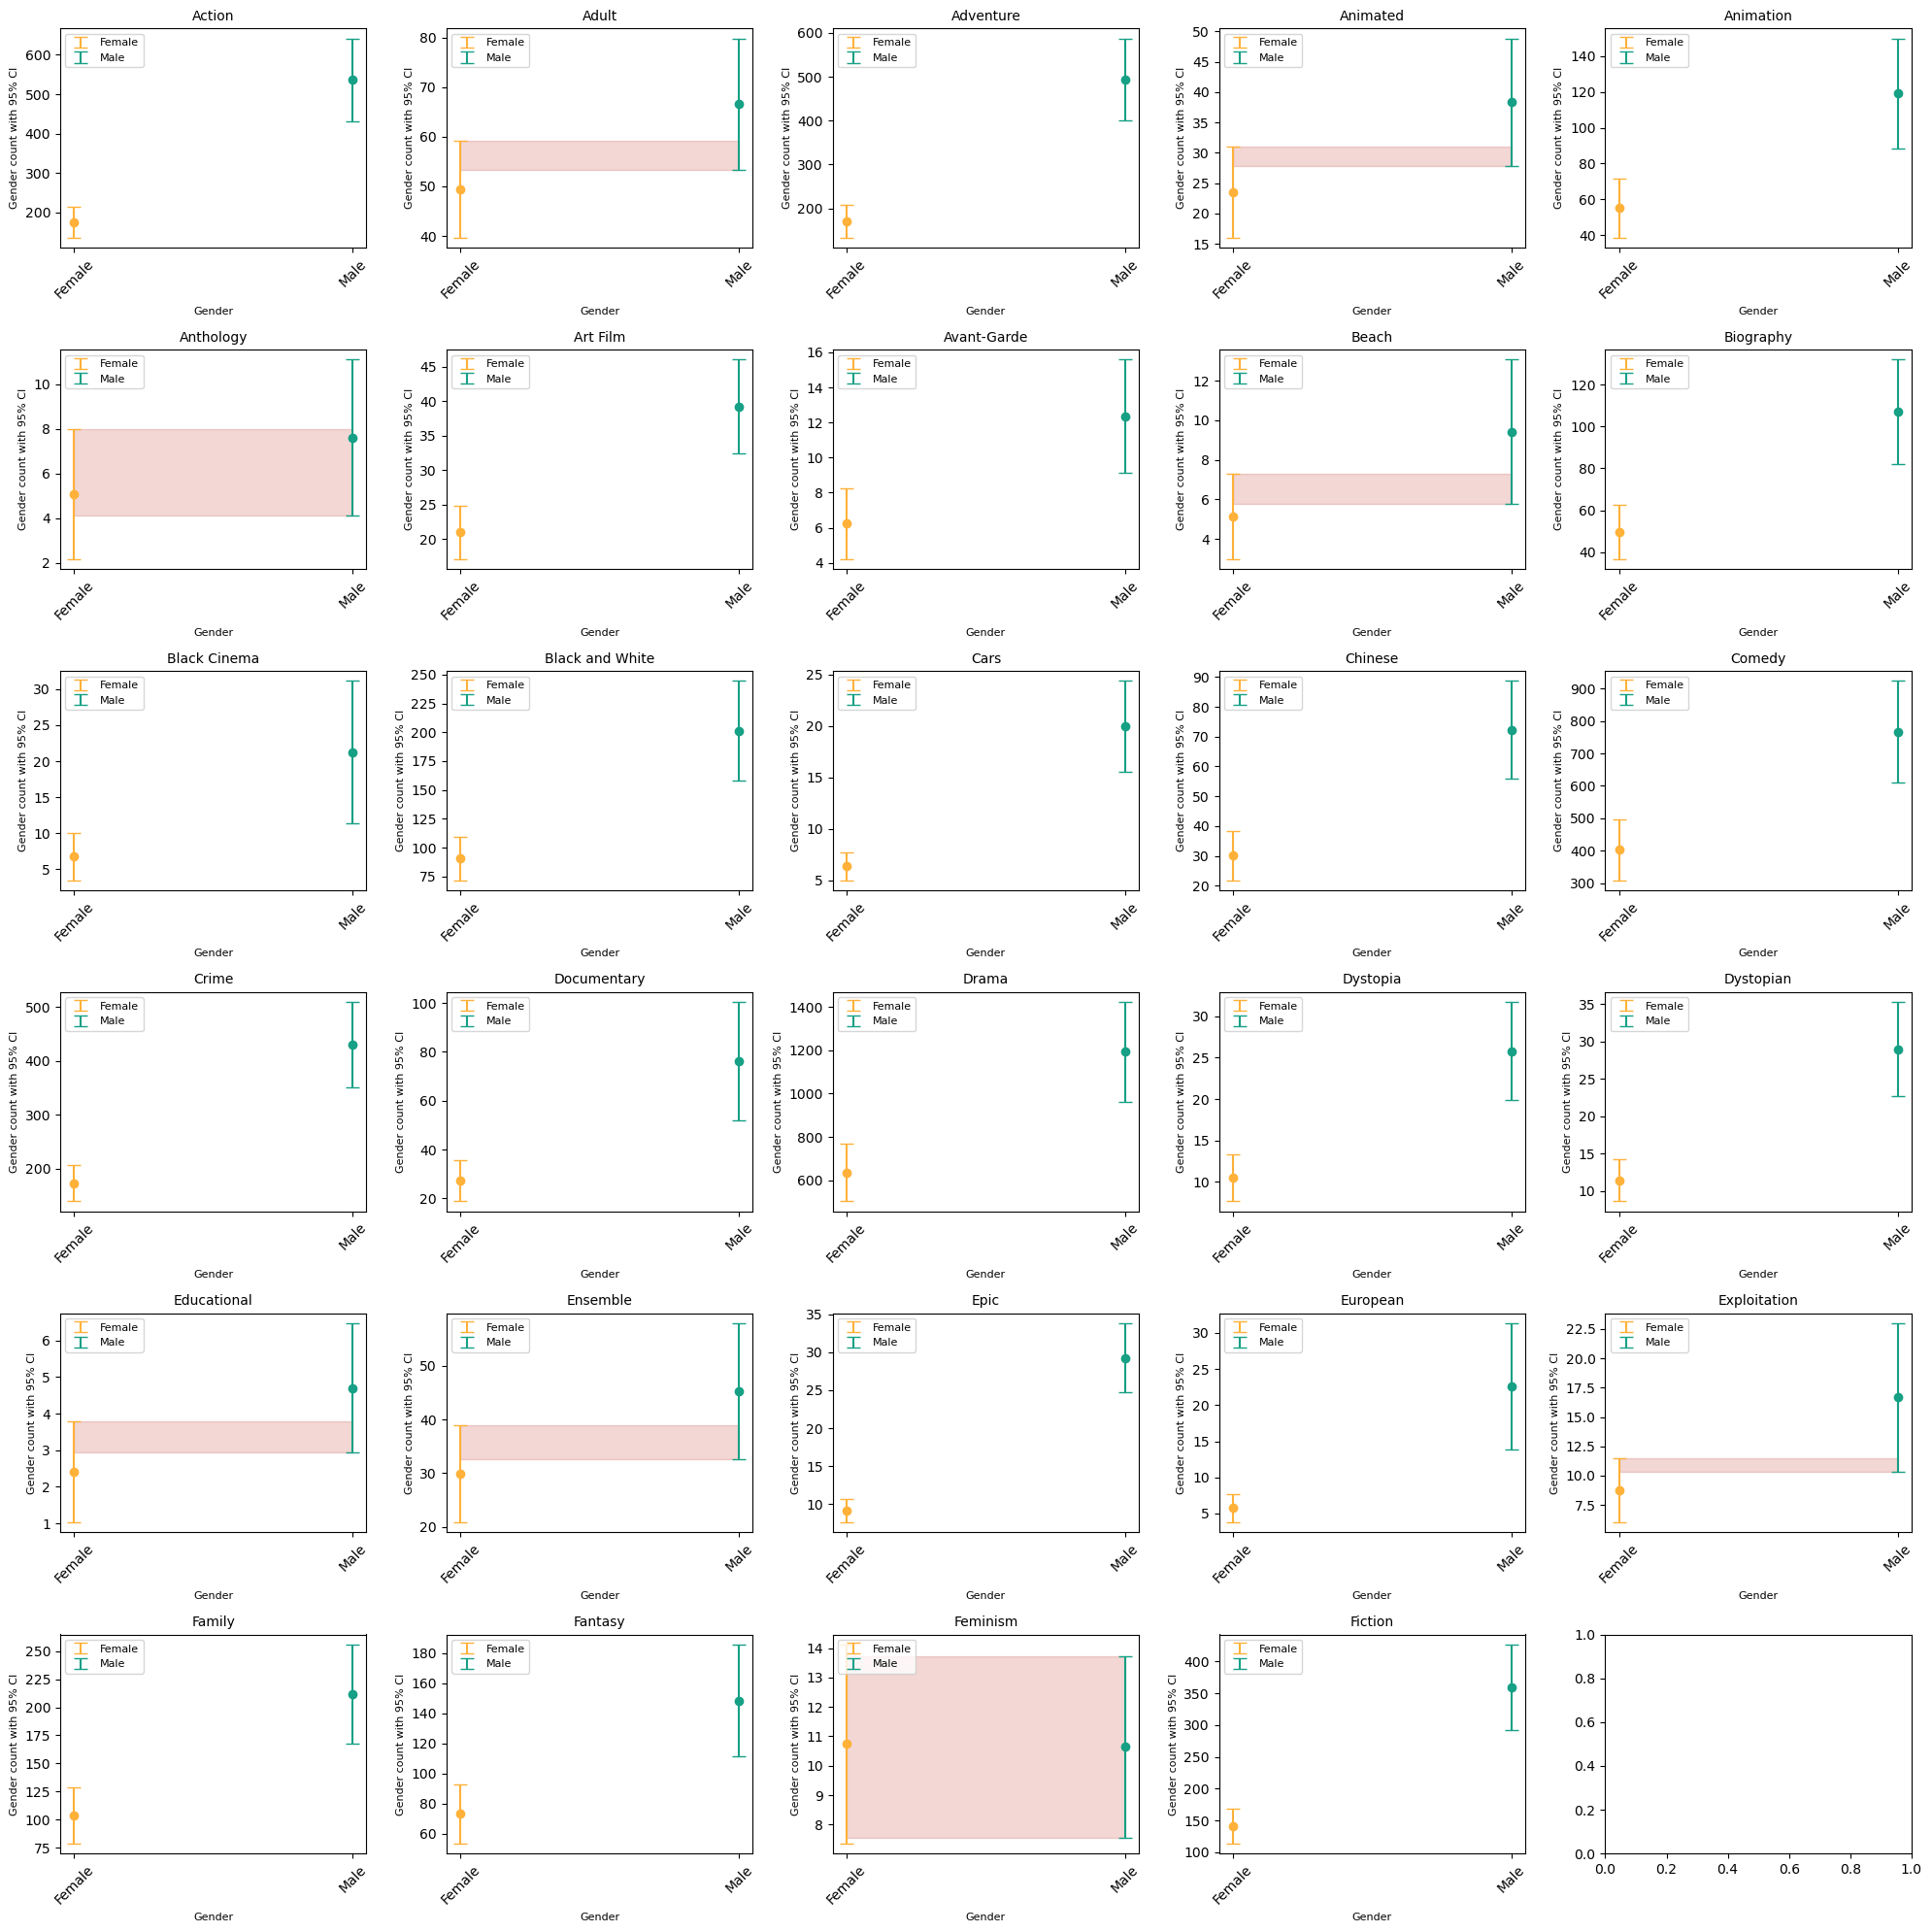

In [206]:
# Make function to create plot for subset of genres because we have 77 of them
def ci_plot_genres(data, start_idx, end_idx):
    fig, axs = plt.subplots(nrows=6, ncols=5, figsize=(20,20))
    plt.subplots_adjust(hspace=0.5, wspace=0.5)

    for (idx, row), ax in zip(data.iloc[start_idx:end_idx].iterrows(), axs.flatten()):
        female_x, male_x = 0.1, 0.9
        ax.errorbar(x=female_x , y=row['F_mean'],
             yerr=[[row['F_mean'] - row['F_CI-']], [row['F_CI+'] - row['F_mean']]],
             fmt='none', capsize=5, color='#FFB139', label='Female')
        ax.errorbar(x=male_x , y=row['M_mean'],
             yerr=[[row['M_mean'] - row['M_CI-']], [row['M_CI+'] - row['M_mean']]],
             fmt='none', capsize=5, color='#16A085', label='Male')
        ax.scatter(x=female_x, y=row['F_mean'], color='#FFB139', zorder=3)
        ax.scatter(x=male_x , y=row['M_mean'], color='#16A085', zorder=3)

        # Fill area for overlapping CIs
        lower_fill = max(row['F_CI-'], row['M_CI-'])
        upper_fill = min(row['F_CI+'], row['M_CI+'])
        if lower_fill < upper_fill:  # Check for overlap
            ax.fill_between([female_x, male_x], lower_fill, upper_fill, color='#C0392B', alpha=0.2)
        
        ax.set_title(row['Genres Reduced'], fontsize=10)
        ax.set_xticks([female_x, male_x])
        ax.set_xticklabels(['Female', 'Male'])
        ax.set_xlabel('Gender', fontsize=8)
        ax.set_ylabel('Gender count with 95% CI', fontsize=8)
        ax.tick_params(axis='x', rotation=45)
        ax.legend(loc='upper left', fontsize=8)

    plt.tight_layout()
    plt.show()

plot_a = ci_plot_genres(character_meta_genre_year_final, 0, 29)

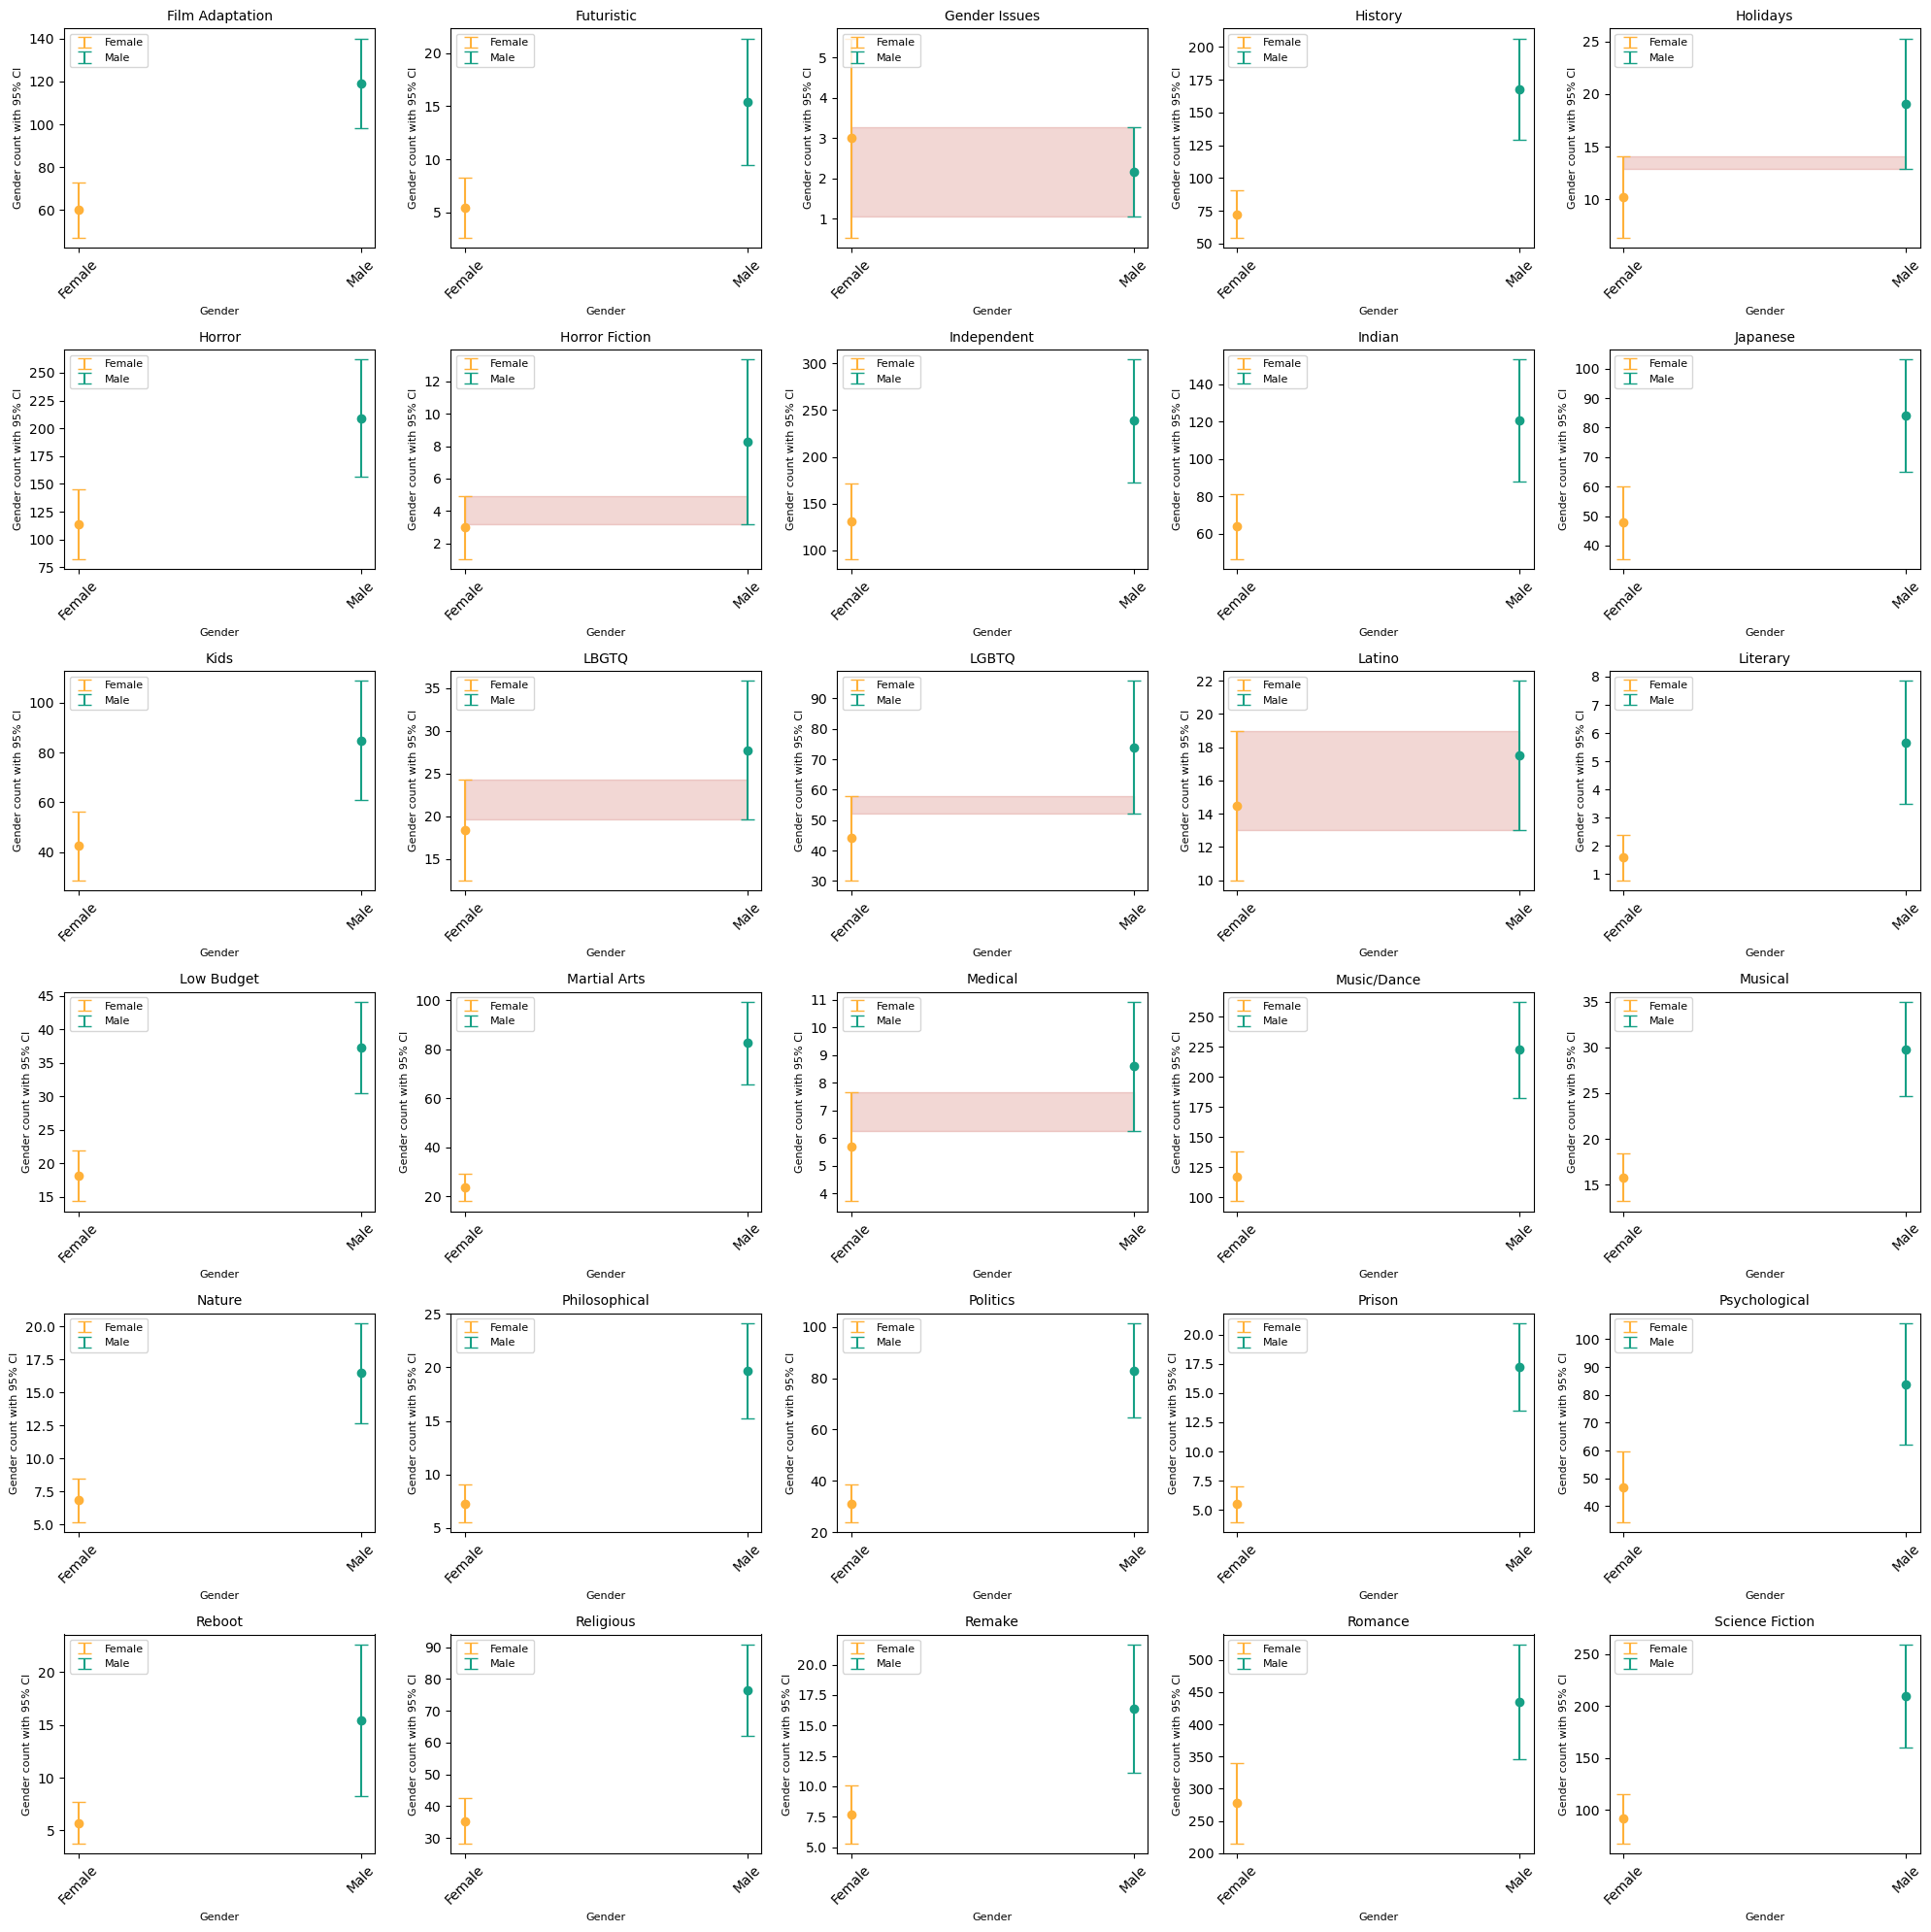

In [208]:
plot_b = ci_plot_genres(character_meta_genre_year_final, 30, 60)

/opt/anaconda3/envs/ada/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/opt/anaconda3/envs/ada/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


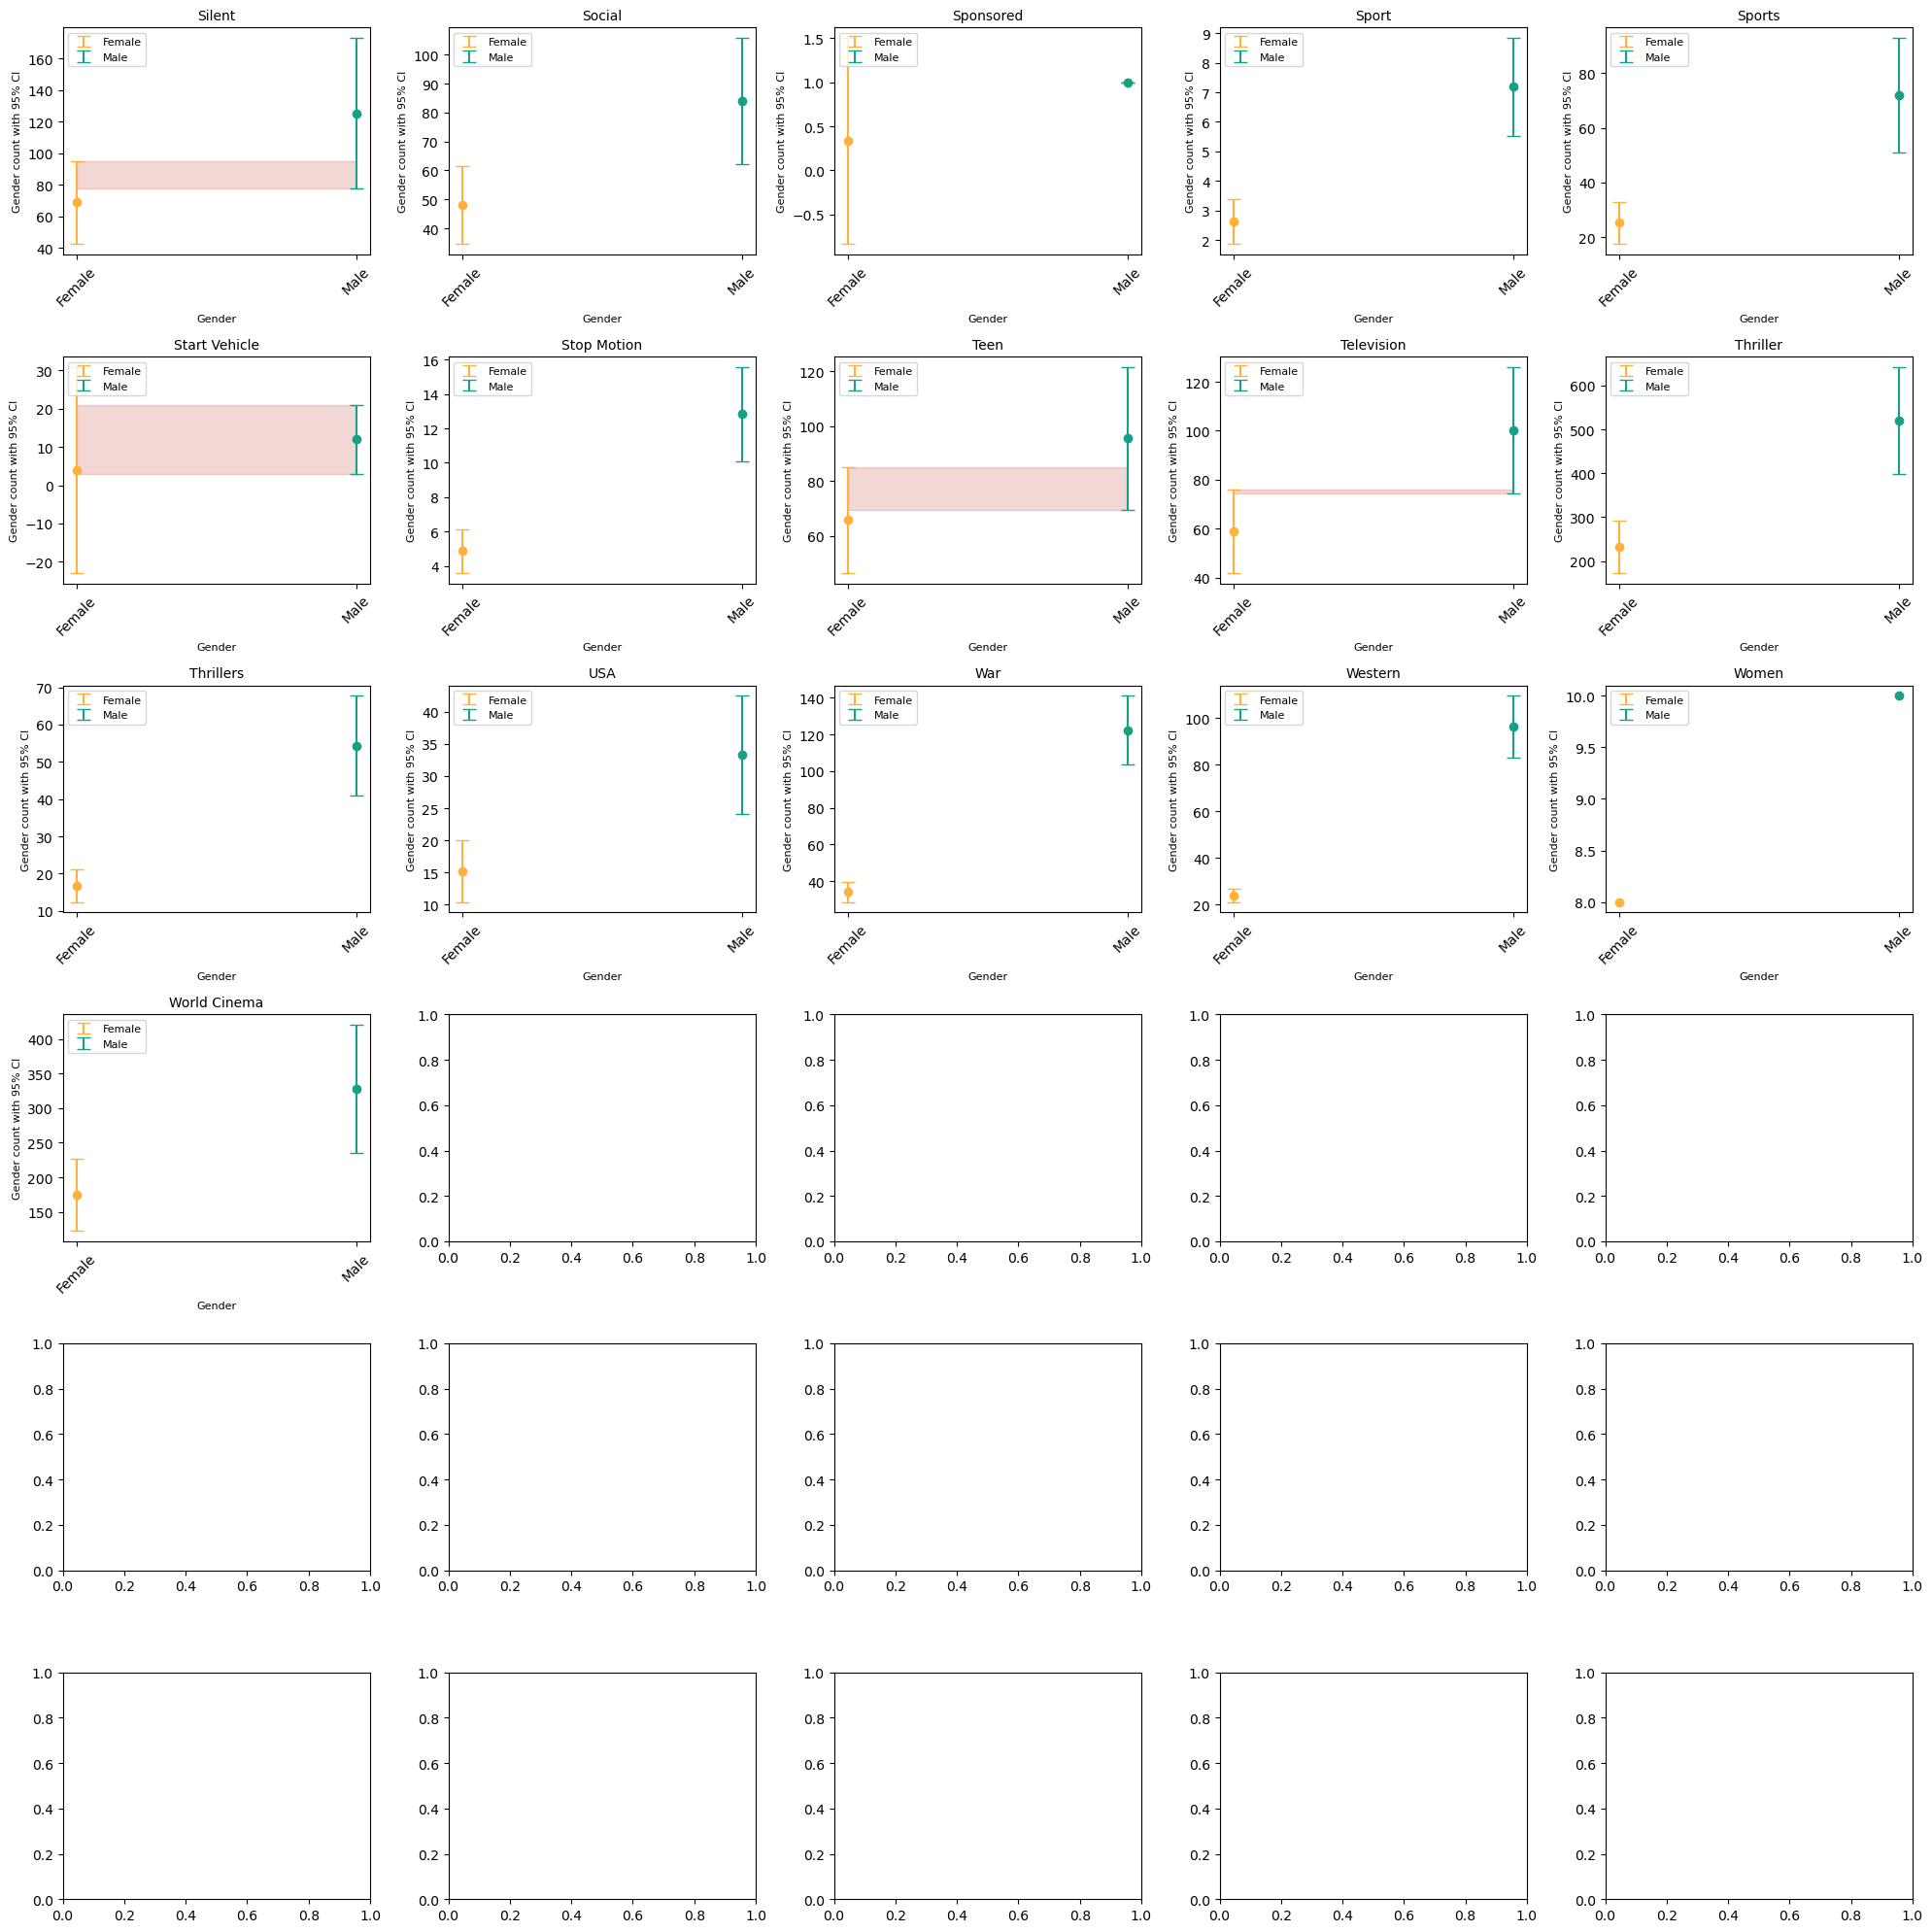

In [210]:
plot_c = ci_plot_genres(character_meta_genre_year_final, 61, 77)

____

Ok, now, we have seen the overlapping confidence intervals. The problem is that for some genres we have such few data that even the confidence intervals don't give us a lot of information. Let's count the number of points we have for each genre per gender and overall. If we have less than 30 points for either gender we'll get a warning.

___

In [232]:
character_meta_genre_year_final['No of samples for F counts'] = character_meta_genre_year_final['F_count_list'].apply(lambda x : len(x))
character_meta_genre_year_final['No of samples for M counts'] = character_meta_genre_year_final['M_count_list'].apply(lambda x : len(x))
character_meta_genre_year_final['No of samples for all genders'] = character_meta_genre_year_final['No of samples for F counts'] + character_meta_genre_year_final['No of samples for M counts'] 

# NOTE: HERE WE CARE ABOUT THE LENGTH OF THE LIST NOT TO SUM ALL OF ITS ELEMENTS! IF YOU HAVE 100 WOMEN IN ONE YEAR IT COUNTS AS 1 SAMPLE!!!

character_meta_genre_year_final.head()

,Genres Reduced,Release_date_list,F_count_list,M_count_list,F_mean,F_CI-,F_CI+,M_mean,M_CI-,M_CI+,CI binary indicator,Female,Male,No of samples for F counts,No of samples for M counts,No of samples for all genders
0,Action,"[1903, 1908, 1909, 1912, 1913, 1914, 1915, 191...","[1, 2, 0, 4, 5, 2, 6, 5, 2, 3, 3, 11, 3, 6, 6,...","[2, 7, 1, 11, 12, 5, 19, 12, 11, 13, 7, 23, 18...",175.839623,136.360313,215.318932,536.707547,432.072440,641.342654,0,F,M,106,106,212
1,Adult,"[1899, 1920, 1927, 1933, 1938, 1940, 1942, 194...","[1, 0, 1, 5, 3, 5, 4, 1, 1, 3, 3, 18, 18, 3, 8...","[0, 2, 4, 3, 3, 5, 10, 3, 0, 1, 14, 14, 34, 8,...",49.454545,39.651891,59.257200,66.515152,53.239795,79.790508,1,F,M,66,66,132
2,Adventure,"[1902, 1903, 1904, 1907, 1910, 1911, 1912, 191...","[2, 1, 0, 2, 1, 0, 1, 6, 9, 9, 5, 4, 10, 8, 27...","[7, 1, 1, 2, 0, 5, 1, 10, 16, 33, 12, 9, 10, 1...",171.263636,133.252082,209.275191,493.690909,399.951236,587.430582,0,F,M,110,110,220
3,Animated,"[1931, 1933, 1935, 1939, 1940, 1941, 1942, 194...","[1, 1, 3, 2, 1, 6, 9, 1, 3, 2, 3, 3, 2, 3, 2, ...","[0, 2, 6, 6, 6, 14, 26, 5, 11, 7, 6, 9, 4, 4, ...",23.560606,16.017735,31.103477,38.363636,27.871197,48.856075,1,F,M,66,66,132
4,Animation,"[1906, 1908, 1913, 1914, 1921, 1923, 1924, 192...","[0, 1, 0, 0, 2, 0, 2, 2, 1, 4, 3, 11, 24, 15, ...","[1, 0, 1, 4, 1, 1, 3, 4, 8, 8, 0, 2, 19, 11, 6...",55.150538,38.600550,71.700525,119.204301,88.537620,149.870982,0,F,M,93,93,186


In [234]:
# Check genres have less than 30 count points in one genre. Do they correspond to the confidence interval overlap?

print('These genres have less than 30 datapoints:')
dummy_df = pd.DataFrame()
for idx, row in character_meta_genre_year_final.iterrows():
    if row['No of samples for F counts'] < 30 or row['No of samples for M counts'] < 30:
        row_df = pd.DataFrame(row[['Genres Reduced', 
                            'No of samples for F counts', 
                            'No of samples for M counts', 
                            'No of samples for all genders',
                            'CI binary indicator']]).transpose()
        dummy_df = pd.concat([dummy_df, row_df])

display(dummy_df)

These genres have less than 30 datapoints:


,Genres Reduced,No of samples for F counts,No of samples for M counts,No of samples for all genders,CI binary indicator
5,Anthology,13,13,26,1
8,Beach,14,14,28,1
10,Black Cinema,27,27,54,0
20,Educational,20,20,40,1
23,European,27,27,54,0
31,Futuristic,22,22,44,0
32,Gender Issues,19,19,38,1
36,Horror Fiction,4,4,8,1
43,Latino,2,2,4,1
44,Literary,24,24,48,0


In [236]:
# Let's see if there are genres with more than 25 points in both females and males where our ci indicator is 1
# If not maybe 25 can be the threshold for the minimum number of data points we need for this
print('These genres with more than 25 datapoints that show CI overlap:')
dummy_df2 = pd.DataFrame()
for idx, row in character_meta_genre_year_final.iterrows():
    if row['No of samples for F counts'] >= 25 and row['No of samples for M counts'] >= 25 and row['CI binary indicator'] == 1:
        row_df = pd.DataFrame(row[['Genres Reduced', 
                            'No of samples for F counts', 
                            'No of samples for M counts', 
                            'No of samples for all genders',
                            'CI binary indicator']]).transpose()
        dummy_df2 = pd.concat([dummy_df2, row_df])

display(dummy_df2)
if not dummy_df2.empty:
    print("Conclusion: There's genres with more than 25 entries that have CI overlap")

These genres with more than 25 datapoints that show CI overlap:


,Genres Reduced,No of samples for F counts,No of samples for M counts,No of samples for all genders,CI binary indicator
1,Adult,66,66,132,1
3,Animated,66,66,132,1
21,Ensemble,67,67,134,1
24,Exploitation,54,54,108,1
27,Feminism,42,42,84,1
29,Filipino,56,56,112,1
34,Holidays,52,52,104,1
41,LBGTQ,43,43,86,1
42,LGBTQ,72,72,144,1
47,Medical,46,46,92,1


There's genres with more than 25 entries that have CI overlap


_____

As you can see there's ofc a correlation between number of points and CI confidence interval overlap. The only cases where we don't see that are when we only have a single point in one or two genders so we can't even compute the variance! So, we need to decide what to do about these genres. Do we just ignore the genres with overlapping F and M counts due to lack of data? Maybe we can still compare them on some other dimension.

_____